# Goal

Create a decision tree without a library, to develop a language detector which distinguishes texts between english and german or X for another language, based on the relative frequencies of the 26 lower case letters "a-z", that means without special characters. The decision tree should have a maximum depth of 4 and a maximum of 10 leaves. 

In [1]:
import sys
import nltk
import math
import itertools
import scipy.stats
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import matplotlib as mpl 
%matplotlib inline

## Daten einlesen

In [2]:
people_en = pd.read_csv('people_wiki_EN.csv', sep=',')
people_de = pd.read_csv('10k-people-raw_DE.csv', sep=';')

## Hilfsfunktionen

In [3]:
def box_plot(dist, title = None):
    chars = [chr(c) for c in range(ord('a'), ord('z') + 1)]
    print(chars)
    fig1, ax1 = plt.subplots(figsize = (18, 8))
    ax1.set_xlabel('Character')
    ax1.set_ylabel('Frequency')
    ax1.boxplot(dist, labels = chars)
    ax1.set_ylim([0, 0.3])
    if title is not None:
        plt.title(title)
    plt.show()

In [4]:
def frequency_plot(mean_en, mean_de):
    chars = [chr(c) for c in range(ord('a'), ord('z')+1)]
    ind = np.arange(len(chars))
    width = 1
    frequency = np.log((np.array(mean_en) / np.array(mean_de)))
    color = ['g' if f > 0 else 'b' for f in frequency]
    
    fig, ax = plt.subplots(figsize = (18, 8))
    rects1 = ax.bar(ind, frequency, width, color = color, edgecolor = 'black')
    ax.set_xticklabels(chars)
    ax.set_xticks(ind + (width * 0.5) - 0.5)
    ax.set_xlabel('Character')
    ax.set_ylim([-2, 2])
    ax.set_ylabel('F')
    ax.set_xlim([-0.5, len(chars) - 0.5])
    ax.text(1, 1.5, 'More frequent in English ', bbox={'facecolor':'green', 'alpha':0.5, 'pad':10})
    ax.text(1, 1.2, 'More frequent in German', bbox={'facecolor':'blue', 'alpha':0.5, 'pad':10})
    ax.text(5.5, 1.35, r'$F = \ln(\frac{mean_e}{mean_d})$', fontsize=25)
    plt.show()

In [5]:
def plot_confusion_matrix(cm, classes, title = 'Confusion matrix', cmap = plt.cm.Greens):
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_norm[np.isnan(cm_norm)] = 0
    cm_norm = np.around(cm_norm, decimals = 3)
        
    plt.imshow(cm_norm, interpolation='nearest', cmap = cmap)
    
    thresh = cm_norm.max() / 2.
    for i, j in itertools.product(range(cm_norm.shape[0]), range(cm_norm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm_norm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## Häufigkeitsverteilungen

In [6]:
def check_if_all_chars_available(item_list):
    """ 
    A helper function which checks that only letters of the alphabet are in the list 
    and that for each letter there is an entry. 
  
        Parameters: 
            item_list (array): The list of items to check conditions for. 
          
        Returns: 
            item_list (array): The correct list of items.
    """
    
    alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
    chars_of_list = []
    for i in range(len(item_list)):
        chars_of_list.append(item_list[i][0])
        list_with_missing_chars = []
    for i in range(len(alphabet)):
        if(alphabet[i] not in chars_of_list):
            list_with_missing_chars.append(alphabet[i])
    indexes_with_missing_chars = []
    for i in range(len(alphabet)):
        if(alphabet[i] in list_with_missing_chars):
            indexes_with_missing_chars.append(i)
    for i in range(len(indexes_with_missing_chars)):
        item_list.insert(indexes_with_missing_chars[i], (alphabet[indexes_with_missing_chars[i]], 0))
        
    return item_list

In [7]:
import collections 
def character_distribution(people):
    '''
    The function to calculate the character distribution over a list (series) of texts. 
  
        Parameters: 
            people (pandas.core.series.Series): The data - all the texts, to get the character distribution for. 
          
        Returns: 
            mean (numpy.ndarray): An array of the mean value for each letter
            std  (numpy.ndarray): An array of the standard deviation value for each letter
            dist (numpy.ndarray): An array which represents the character distribution for each text.
    '''
    
    item_list = []
    fdist = []
    alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
    dist = np.zeros(shape = (len(people), 26))
    for i in range(len(people)):
        fdist.append(nltk.FreqDist(ch.lower() for ch in people[i] if ch.isalpha()))
        fdist[i] = collections.OrderedDict(sorted(fdist[i].items()))
        item_list.append(list(fdist[i].items()))
        item_list[i] = check_if_all_chars_available(item_list[i])
        dist[i] = [frequency for (char,frequency) in item_list[i] if char in alphabet]
        char_sum = 0
        for k in range(len(dist[i])):
            char_sum += dist[i][k]
        for j in range(len(dist[i])):
            dist[i][j] = dist[i][j]/char_sum
        
    mean = np.mean(dist, axis=0)
    std = np.std(dist, axis=0)    
   
    return mean, std, dist

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


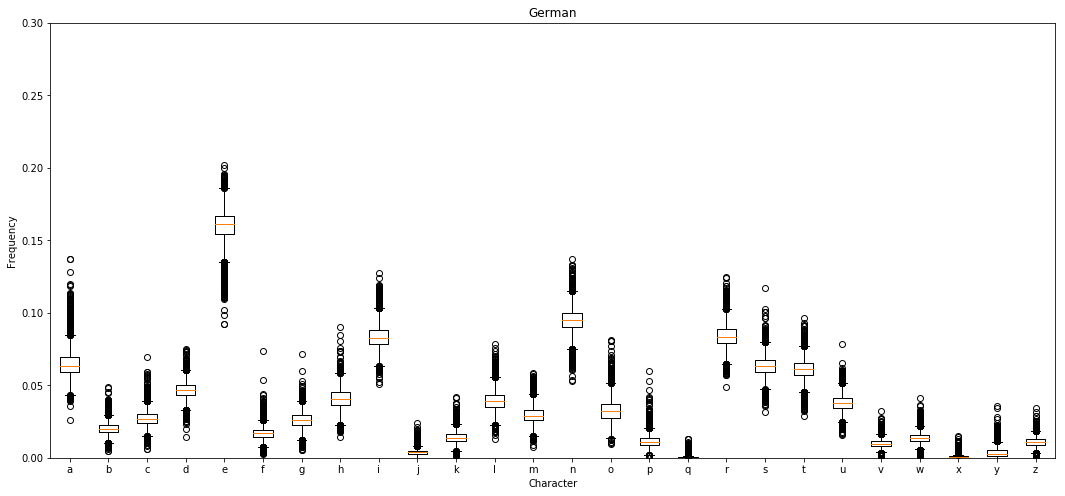

In [8]:
mean_de, std_de, dist_de = character_distribution(people_de['text'])
box_plot(dist_de, 'German')

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


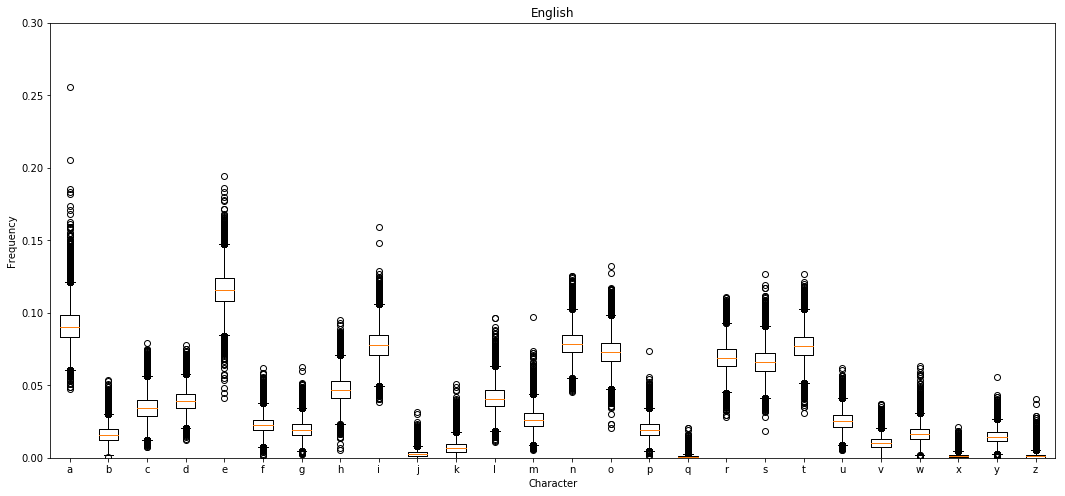

In [9]:
mean_en, std_en, dist_en = character_distribution(people_en['text'])
box_plot(dist_en, 'English')

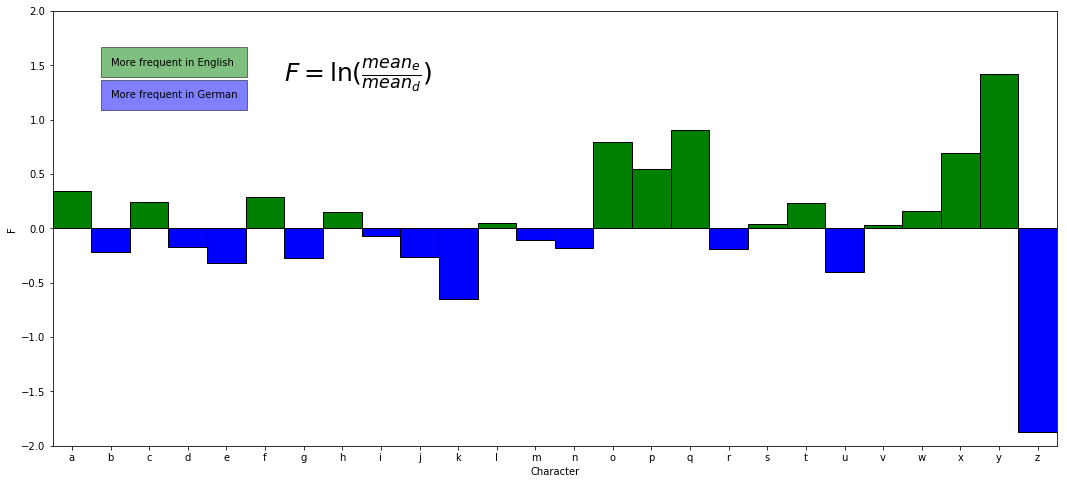

In [10]:
frequency_plot(mean_en, mean_de)

## Spracherkennung

Wie im Unterricht gelernt und in der Aufgabe 13 (UM2) besprochen, wähle ich die Buchstaben anhand der Fläche unterhalb dem Produkt der beiden Dichtefunktionen

$$
K = \int_{x=-\infty}^{\infty}{\frac{1}{\sqrt{2\pi\sigma_D^2}}e^{-\frac{\left(x-\mu_D\right)^2}{2\sigma_D^2}}\cdot \frac{1}{\sqrt{2\pi\sigma_E^2}}e^{-\frac{\left(x-\mu_E\right)^2}{2\sigma_E^2}} dx}
$$

In [11]:
#Von Aufgabe 13 (UM2)
from scipy.integrate import quad
import sympy
def integrand(x):
    return 1/std_de[i]/std_en[i]*sympy.exp(-(x-mean_de[i])**2/2/std_de[i]**2-(x-mean_en[i])**2/2/std_en[i]**2)

In [12]:
K = []
for i in np.arange(0,26):
     K.append(quad(integrand,0,1)[0])
K_max = max(K)
for i in np.arange(0,26):
     K[i] /= K_max

alphabet = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']
K_grenze = sorted(K)[4]
counter = 0
for i in range(len(K)):
    counter += 1
    if(K[i] <= K_grenze):
        letter = alphabet[counter-1]
        print(K[i], '- letter: ', letter)

0.024952664260223224 - letter:  a
0.002567353019697324 - letter:  e
0.0007280888777393105 - letter:  o
0.043644772176741835 - letter:  y
0.028335692599044168 - letter:  z


In [57]:
import math 
def language_tree(mean_de, mean_en, texts):
    '''
    The function to generate a decision tree to predict the correct language based on the character distribution. 
    Decision tree's max depth: 4, max amount of leafes: 10
  
        Parameters: 
            mean_de (numpy.ndarray): An array of the mean value for each letter for the German language. 
            mean_en (numpy.ndarray): An array of the mean value for each letter for the English language.
            text (pandas.core.series.Series): The data - all the textes 

        Returns: 
            lang (list): A list with language labels
    '''
  
    _, _, dist_test = character_distribution(texts)
  
    lang = []
    for i in range(texts.shape[0]):
        
        '''
        Letter i use: a => [0], e => [4], o => [14], n => [13] (high frequency in german language), 
        w => [22] (more frequent letter in english than in other languages ('X'))
        The letters are chosen based on the calculation above 
        '''  
        
        if dist_test[i][4] <= (mean_de[4] - std_de[4]):
            if dist_test[i][14] >= (mean_en[14] - std_en[14])*0.98 and dist_test[i][14] <= (mean_en[14] + std_en[14]):
                    lang.append('E')
            else:
                if dist_test[i][0] >= (mean_en[0] - std_en[0])*0.925 and dist_test[i][0] <= (mean_en[0] + std_en[0])*0.899:
                     lang.append('E')
                else: 
                    if dist_test[i][22] >= (mean_en[22] - std_en[22])*0.70 and dist_test[i][22] <= (mean_en[22] + std_en[22])/0.70:
                        lang.append('E')
                    else:
                        lang.append('X')
        elif dist_test[i][4] >= mean_de[4] - std_de[4]:
            if dist_test[i][13] >= (mean_de[13] - std_de[13]) * 0.9:
                lang.append('G')
            else:
                lang.append('X')
                
    return lang

In [58]:
def accuracy(cm):
    i = np.eye(cm.shape[0])
    return (i * cm).sum() / cm.sum()

In [67]:
people_test = pd.read_csv('Language_test.csv', sep=';', quotechar='|')
lang_true = np.array(people_test['language'])

In [68]:
lang = language_tree(mean_de, mean_en, people_test['text'])
cm = confusion_matrix(lang_true, lang)

In [69]:
accuracy_ = accuracy(cm)
print("Achieved accuracy: ", accuracy_)

Achieved accuracy:  0.8996539792387543


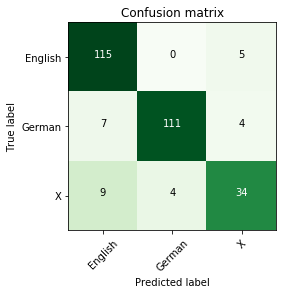

In [70]:
plot_confusion_matrix(cm, ['English', 'German', 'X'])